In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

--2022-09-06 09:28:39--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 142.251.16.128, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   233MB/s    in 3.3s    

2022-09-06 09:28:43 (235 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [3]:
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

--2022-09-06 09:29:00--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 142.251.16.128, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259479040 (1.2G) [application/x-tar]
Saving to: ‘CUB_200_2011.tar’

CUB_200_2011.tar    100%[===================>]   1.17G   236MB/s    in 5.2s    

2022-09-06 09:29:05 (232 MB/s) - ‘CUB_200_2011.tar’ saved [1259479040/1259479040]



In [4]:
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

In [5]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'
base_dir = '/content/tmp/data'

In [6]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [7]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

In [8]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir, 'PetImages/Cat')
print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [9]:
raw_birds_dir = '/content/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

In [10]:
for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  # print(subdir_path)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), base_birds_dir)
  

In [11]:
# shutil.rmtree(base_birds_dir)

In [12]:
len(os.listdir(base_birds_dir))

11788

Sample cat image:


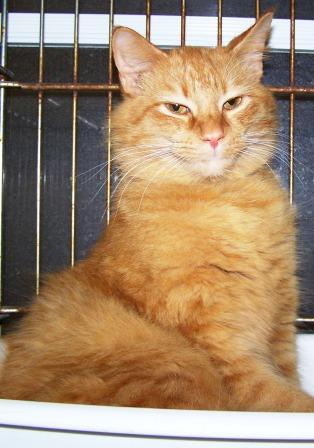


Sample dog image:


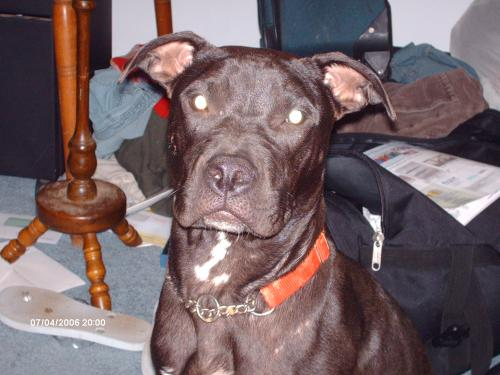


Sample bird image:


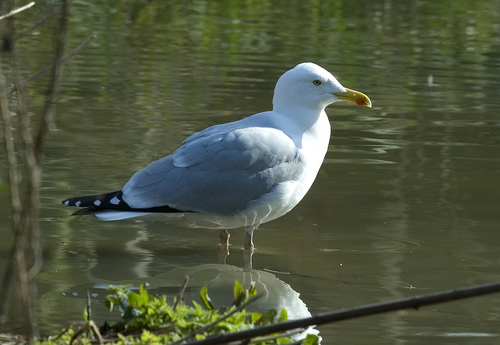

In [13]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

In [14]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                 'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [15]:
def move_to_destination(origin, destination, split_percentage):
  num_images = int(len(os.listdir(origin)) * split_percentage)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)


In [16]:
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)

In [17]:
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

In [18]:
!find /content/tmp/data/eval/ -size 0 

/content/tmp/data/eval/cats/666.jpg


In [19]:
!find /content/tmp/data/eval/ -size 0 -exec rm {} +

In [20]:
!find /content/tmp/data/train/ -type f ! -name "*.jpg"

In [21]:
!find /content/tmp/data/eval/ -type f ! -name "*.jpg" -exec rm {} +

In [22]:
!find /content/tmp/data/eval/ -type f ! -name "*.jpg"

In [23]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8750 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


In [24]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/' + dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/' + dir))

In [25]:
def copy_with_limit(origin, destination, split_percentage):
  num_images = int(len(os.listdir(origin)) * split_percentage)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

In [26]:
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir,'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)


In [27]:
# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1750 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


In [28]:
from tensorflow.keras import layers, models, optimizers

In [29]:
from tensorflow.python import metrics
def create_model():
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
      layers.MaxPool2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dense(3, activation='relu'),
  ])

  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [30]:
imbalanced_model = create_model()
imbalanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/tmp/data/imbalanced/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 11325 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


In [32]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [33]:
imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [34]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# imbalanced_history = imbalanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

In [35]:
def get_training_metrics(history):
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

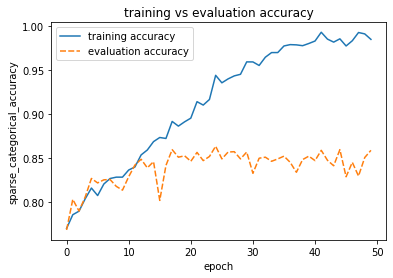

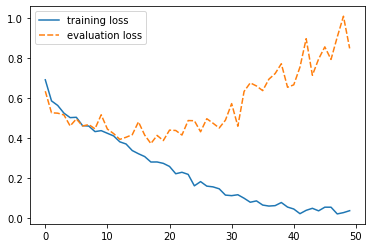

In [36]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({'training accuracy': acc, 'evaluation accuracy': val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  loss_plot = pd.DataFrame({'training loss': loss, 'evaluation loss': val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  acc_plot.set_title('training vs evaluation loss')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('loss')
  plt.show()

plot_train_eval(imbalanced_history)

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [38]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4852 images belonging to 3 classes.


In [39]:
y_true = val_gen_no_shuffle.classes
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

In [40]:
predictions_imbalanced

array([[7.9309672e-02, 9.2069030e-01, 9.4671444e-09],
       [1.0000000e+00, 3.8238544e-15, 8.3644550e-11],
       [9.9999964e-01, 1.0344586e-07, 2.3394735e-07],
       ...,
       [3.5205569e-10, 9.7689581e-01, 2.3104254e-02],
       [3.4046680e-16, 9.9991298e-01, 8.7035311e-05],
       [1.0000000e+00, 1.5910531e-10, 5.3786614e-08]], dtype=float32)

In [41]:
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

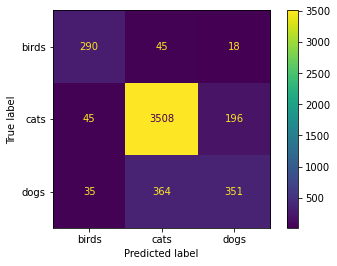

In [42]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [46]:
y_true

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [47]:
unique, counts = np.unique(y_true, return_counts=True)

In [48]:
unique, counts

(array([0, 1, 2], dtype=int32), array([ 353, 3749,  750]))

In [49]:
balanced_model = create_model()

In [50]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/tmp/data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 25751 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [53]:
train_generator.class_indices

{'birds': 0, 'cats': 1, 'dogs': 2}

In [67]:
balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [68]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 11036 images belonging to 3 classes.


In [69]:
y_true = val_gen_no_shuffle.classes
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

y_pred_balanced = tf.argmax(predictions_balanced, axis=1)


In [70]:
predictions_balanced.shape

(11036, 3)

In [71]:
# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8636281261326567
Balanced Accuracy Score: 0.8647221799730266


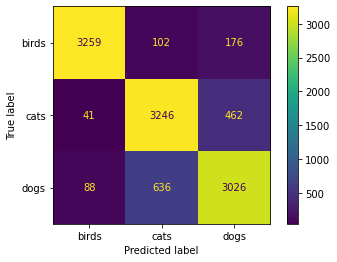

In [72]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

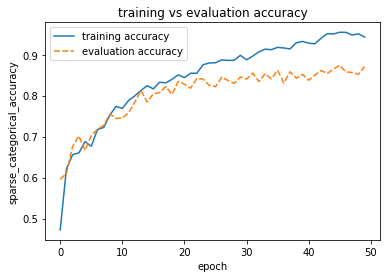

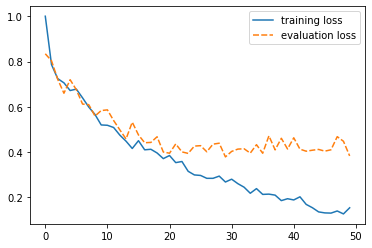

In [74]:
plot_train_eval(balanced_history)

In [73]:
unique, counts = np.unique(y_true, return_counts=True)
unique, counts

(array([0, 1, 2], dtype=int32), array([3537, 3749, 3750]))

In [75]:
augmented_model = create_model()

In [78]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/tmp/data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/tmp/data/eval',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 25751 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


(150, 150, 3)
(1, 150, 150, 3)

Transformation number: 0



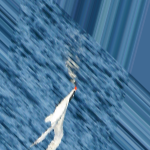


Transformation number: 1



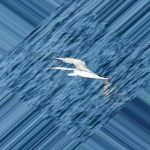

In [89]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def display_transformation(gen):
  train_birds_dir = '/content/tmp/data/train/birds'
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  print(sample_array.shape)
  sample_array = sample_array[None, :]
  print(sample_array.shape)

  for iteration, array in zip(range(2), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)



sample_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.5,
    zoom_range=0.5,
    vertical_flip=True,
    horizontal_flip=True
)

display_transformation(sample_gen)

(150, 150, 3)
(1, 150, 150, 3)

Transformation number: 0



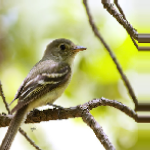


Transformation number: 1



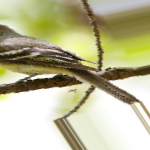


Transformation number: 2



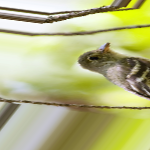


Transformation number: 3



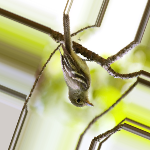

In [86]:
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformation(sample_gen)


In [87]:
augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

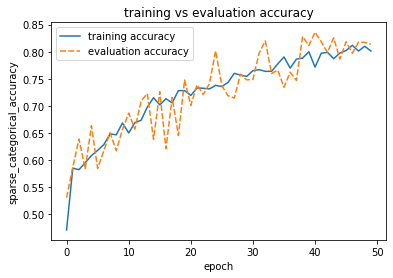

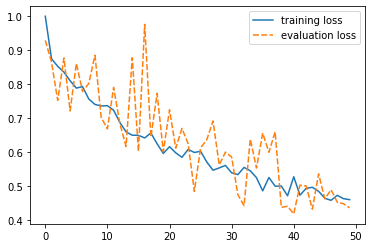

In [88]:
plot_train_eval(augmented_history)